In [1]:
!pip install mne

In [61]:
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pandas import read_csv
from datetime import datetime, timedelta
from pandas import read_json
import traceback
import math
from math import fabs, log 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories
from sklearn.svm import SVC
import pickle


In [19]:
print(__doc__)

data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
#print(conds.head(5))

max_trigger = 92
conds = conds[:max_trigger] 

Automatically created module for IPython interactive environment
   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1


In [20]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
#print(conditions[:10])


['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In [21]:
event_id = dict(zip(conditions, conds.trigger + 1))
#event_id['0/human bodypart/human/not-face/animal/natural']

1

In [22]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [29]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

2760 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2760 events and 601 original time points ...
2 bad epochs dropped


In [24]:
# epochs['face'].average().plot()
# epochs['not-face'].average().plot()

In [65]:
X = epochs.copy().crop(0.095, 0.15).get_data()
y = epochs.events[:, 2]
classes = set(y)

In [72]:
classes = set(y)

In [67]:
y_test.shape

(826,)

In [68]:
scalers = {}
nFeatures = 1000
testSize = -826
np.random.seed(0)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]
X_train = X[:testSize]
X_test = X[testSize:]
y_train = y[:testSize]
y_test = y[testSize:]
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2] )

pca = PCA(nFeatures)
X_train = pca.fit_transform(X_train)

for i in range(X.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2] )
X_test = pca.transform(X_test)
pickle.dump(pca, open("pca_%s"%nFeatures, "wb"))

In [0]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.

from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
clf = GridSearchCV(SVC(probability=True, gamma="auto"),
                       param_grid={'kernel':['linear', 'rbf', 'poly'], 'C':[1, 10],
                                   'probability': [True], 'degree': [5, 50, 500]},
                       cv=10,
                       n_jobs = -1,
                       refit=True)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [0]:
# Save Model
path = "" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = "clf_save_test"
filename = path + name
pickle.dump(clf, open(name, "wb"))

In [0]:
# Load Model
loaded_model = pickle.load(open(name, "rb"))
y_predTest = loaded_model.predict_proba(X_test)

In [0]:
np.array_equal(y_pred, y_predTest)

In [74]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y_test == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

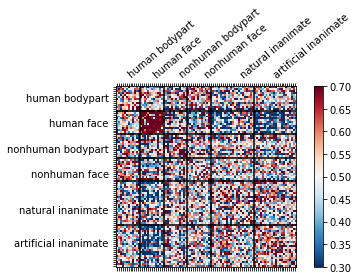

In [75]:
labels = ['']*5+['human bodypart']+['']*12+['human face']+['']*12+['nonhuman bodypart']+['']*12+['nonhuman face']+['']*17+['natural inanimate']+['']*16+['artificial inanimate']+['']*6

fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(12, color='k') ## human bodypart
ax.axhline(24, color='k') ## human face
ax.axhline(36, color='k') ## nonhuman bodypart
ax.axhline(48, color='k') ## nonhuman face
ax.axhline(70, color='k') ## natural inanimate
ax.axvline(12, color='k') ## human bodypart
ax.axvline(24, color='k') ## human face
ax.axvline(36, color='k') ## nonhuman bodypart
ax.axvline(48, color='k') ## nonhuman face
ax.axvline(70, color='k') ## natural inanimate
plt.colorbar(im)
plt.tight_layout()
plt.show()

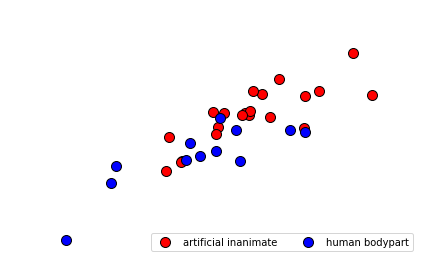

In [76]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()

In [41]:
y_train.shape

(1932,)

In [42]:
X_train.shape

(1932, 306, 56)

In [70]:
#esemble Methods 
#esemble Methods 

clf1 = SVC(probability=True, kernel="linear", gamma="auto")
clf2 = SVC(probability=True, kernel="rbf", gamma="auto")
clf3 = SVC(probability=True, kernel="poly", gamma="auto")

clf4 = VotingClassifier(estimators=[('linear', clf1), ('rbf', clf2), ('poly', clf3)], voting='soft', weights=[1, 2, 1])
                       
params = {'linear__C': [1,10], 'rbf__C': [1,10], 'poly__C': [1,10],'linear__degree': [5, 50, 500],'rbf__degree': [5, 50, 500],'poly__degree': [5, 50, 500] }
        
grid = RandomizedSearchCV(estimator=clf4,
                    cv=3,
                    param_distributions=params,
                    n_jobs = -1,
                    refit=True,
                    n_iter = 30, 
                    random_state=10,
                    verbose=2)
grid.fit(X_train, y_train)
y_pred = grid.predict_proba(X_test)
name = "3svc_together_%s"%nFeatures
#filename = path + name
pickle.dump(grid, open(name, "wb"))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 18.3min finished
/anaconda3/envs/neur182/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'gini__n_estimators': n_estimators,
               'gini__max_features': max_features,
               'gini__max_depth': max_depth,
               'gini__min_samples_split': min_samples_split,
               'gini__min_samples_leaf': min_samples_leaf,
               'gini__bootstrap': bootstrap,
               'entropy__n_estimators': n_estimators,
               'entropy__max_features': max_features,
               'entropy__max_depth': max_depth,
               'entropy__min_samples_split': min_samples_split,
               'entropy__min_samples_leaf': min_samples_leaf,
               'entropy__bootstrap': bootstrap,
              }


RFC1 = RandomForestClassifier(criterion = 'gini')
RFC2 = RandomForestClassifier(criterion = 'entropy')
RFC = VotingClassifier(estimators=[('gini', RFC1), ('entropy', RFC2)], voting='soft', weights=[1, 1])
RFC_RandomSearch = RandomizedSearchCV(estimator = RFC,
                                      param_distributions = random_grid,
                                      n_iter = 100, cv = 3, verbose=3,
                                      random_state=10, n_jobs = -1)

RFC_RandomSearch.fit(X_train, y_train)

y_pred = RFC_RandomSearch.predict_proba(X_test)
name = "2trees_together_%s"%nFeatures
#filename = path + name
pickle.dump(RFC_RandomSearch, open(name, "wb"))



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 33.0min
/anaconda3/envs/neur182/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 220.0min


In [ ]:
n_estimators = [int(x) for x in numpy.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in numpy.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'gini__n_estimators': n_estimators,
               'gini__max_features': max_features,
               'gini__max_depth': max_depth,
               'gini__min_samples_split': min_samples_split,
               'gini__min_samples_leaf': min_samples_leaf,
               'gini__bootstrap': bootstrap,
               'entropy__n_estimators': n_estimators,
               'entropy__max_features': max_features,
               'entropy__max_depth': max_depth,
               'entropy__min_samples_split': min_samples_split,
               'entropy__min_samples_leaf': min_samples_leaf,
               'entropy__bootstrap': bootstrap,
               'linear__C': [1,10], 
               'rbf__C': [1,10], 
               'poly__C': [1,10],
               'linear__degree': [5, 50, 500],
               'rbf__degree': [5, 50, 500],
               'poly__degree': [5, 50, 500] 
              }


RFC1 = RandomForestClassifier(criterion = 'gini')
RFC2 = RandomForestClassifier(criterion = 'entropy')
clf1 = SVC(probability=True, kernel="linear", gamma="auto")
clf2 = SVC(probability=True, kernel="rbf", gamma="auto")
clf3 = SVC(probability=True, kernel="poly", gamma="auto")
vote = VotingClassifier(estimators=[('linear', clf1), ('rbf', clf2), ('poly', clf3), ('gini', RFC1), ('entropy', RFC2)], voting='soft', weights=[1, 2, 1, 1, 1])

RandomSearch = RandomizedSearchCV(estimator = vote,
                                      param_distributions = random_grid,
                                      n_iter = 100, cv = 3, verbose=3,
                                      random_state=10, n_jobs = -1)

RandomSearch.fit(X_train, y_train)

y_pred = RandomSearch.predict_proba(X_test)
name = "5models_%s"%nFeatures
#filename = path + name
pickle.dump(RandomSearch, open(name, "wb"))


In [ ]:
!git add *
!git commit -m "adding models with 1000 features"
!git push

In [0]:
# Code for one hot encoding if needed
numCats = 92
numTrials = X.shape[0]

oneHotY = np.zeros((numTrials, numCats))
for i in range(numTrials):
    oneHotY[i][y[i]-1] = 1
